In [1]:
# pip dependencies
!pip install pytorch-lightning -q
!pip install "ray[tune]==1.11.0" -q
!pip install comet_ml -q

In [2]:
from typing import Dict

import numpy as np
import pandas as pd
from recommender_utils import RecommenderUtils
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm
import multiprocessing
from collections import defaultdict

import torch
from torch.utils.data import Dataset
import torch.optim as optim
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision.transforms import ToTensor

import pytorch_lightning as pl
from ray import tune

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 200)

# Params

In [3]:
random_seed = 42

params = {"user_min_bought" : 5,
          "item_min_bought" : 5,
          "split_count" : 5,
          "split_fraction" : 0.2,
          "fraction" : None,
          "random_seed" : random_seed,
          "batch_size" : 512,
         }
np.random.seed(random_seed)

# Data Engineering

In [4]:
# IMPORTANT COLUMNS / GROUPS
USER_ID = "userId"
ITEM_ID = "movieId"
RATING="rating"

df_ratings =pd.read_csv("/kaggle/input/movielens-1m-dataset/ratings.csv", sep=";")
df_ratings[:5]

,userId,movieId,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [5]:
def __default_filter_ratings(df_ratings, params: Dict):
    # explicit to implicit
    df_ratings = df_ratings[df_ratings[RATING] >= 4].reset_index()
    df_ratings[RATING] = 1
    
    # extract params
    user_min_bought = params["user_min_bought"]
    item_min_bought = params["item_min_bought"]

    # threshold interactions
    df_txn = RecommenderUtils.threshold_interactions_df(df_ratings, USER_ID, ITEM_ID,
                                                        user_min_bought, item_min_bought)

    return df_txn

def split_train_test(interactions, params: Dict):
    split_count = params["split_count"]
    split_fraction = params["split_fraction"]
    fraction = params["fraction"]
    random_seed = params["random_seed"]

    np.random.seed(random_seed)

    train, test, test_users = RecommenderUtils.train_test_split_sparse(
        interactions, split_count, split_fraction=split_fraction, fraction=fraction)

    # create a train set where the train-only users have unknown recos
    # this is for training set evaluation
    eval_train = train.copy()
    non_eval_users = list(set(range(train.shape[0])) - set(test_users))

    eval_train = eval_train.tolil()
    for u in non_eval_users:
        eval_train[u, :] = 0.0
    eval_train = eval_train.tocsr()
    return {"train": train, "test": test, "eval_train": eval_train}

In [6]:
# dedupe ratings
df_ratings = df_ratings[[USER_ID, ITEM_ID, RATING]].drop_duplicates()

utils = RecommenderUtils(user_id=USER_ID, item_id=ITEM_ID, rating=RATING)
print("Before thresholding interactions")
utils.print_ratings_shape(df_ratings)

print("After")
df_ratings = __default_filter_ratings(df_ratings, params)
utils.print_ratings_shape(df_ratings)

# to sparse matrix
interactions, rid_to_idx, idx_to_rid, cid_to_idx, idx_to_cid = \
    RecommenderUtils.df_to_matrix(df_ratings, USER_ID, ITEM_ID, interaction_var=RATING)

Before thresholding interactions
Number of users: 6040
Number of items: 3706
Number of rows: (1000209, 3)
Sparsity: 0.044683625622312845
After
Starting interactions info
Number of rows: 6038
Number of cols: 3533
Sparsity: 2.697%
Ending interactions info
Number of rows: 6034
Number of columns: 3125
Sparsity: 3.046%
Number of users: 6034
Number of items: 3125
Number of rows: (574376, 4)
Sparsity: 0.030460775604905534


In [7]:
# split train set to test set
split = split_train_test(interactions, params)
train = split["train"]
test = split["test"]

# split train set to validation set
# for splitting to validation, get only 10%
params["split_fraction"] = 0.1
split_val = split_train_test(train, params)
train = split_val["train"]
val = split_val["test"]

train = train.astype(np.float32)
val = val.astype(np.float32)
test = test.astype(np.float32)

eval_train = split_val["eval_train"]
num_users = train.shape[0]
num_items = train.shape[1]

In [8]:
train, val, test

(<6034x3125 sparse matrix of type '<class 'numpy.float32'>'
 	with 418367 stored elements in Compressed Sparse Row format>,
 <6034x3125 sparse matrix of type '<class 'numpy.float32'>'
 	with 43581 stored elements in Compressed Sparse Row format>,
 <6034x3125 sparse matrix of type '<class 'numpy.float32'>'
 	with 112428 stored elements in Compressed Sparse Row format>)

## PyTorch Datasets and Loaders
- This is needed to load into PyTorch.
- We have two versions -- train, and test
- Train contains the sparse matrix for training.
- Test contains the training matrix and the target matrix.


In [9]:
class RecoSparseDataset(Dataset):
    def __init__(self, sparse_mat):
        self.sparse_mat = sparse_mat
        
    def __len__(self):
        return self.sparse_mat.shape[0]

    def __getitem__(self, idx):
        batch_matrix = self.sparse_mat[idx].toarray().squeeze()
        return batch_matrix
    
class RecoSparseTestSet(Dataset):
    """
    The test dataset contains the training and test matrices.
    The latter should be predicted from the training
    """
    def __init__(self, train_mat, test_mat):
        self.train_mat = train_mat
        self.test_mat = test_mat
        assert train_mat.shape == test_mat.shape

    def __len__(self):
        return self.train_mat.shape[0]

    def __getitem__(self, idx):
        train_matrix = self.train_mat[idx].toarray().squeeze()
        test_matrix = self.test_mat[idx].toarray().squeeze()
        return train_matrix, test_matrix
    
    
###
batch_size = params["batch_size"]
num_workers = multiprocessing.cpu_count()

train_loader = torch.utils.data.DataLoader(RecoSparseDataset(train), batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(RecoSparseTestSet(train, val), batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(RecoSparseTestSet(train, test), batch_size=batch_size, shuffle=False, num_workers=num_workers)

# Model
- TODO: definitions

## TopNRecommender base class

In [10]:
class TopNRecommender(pl.LightningModule):
    def __init__(self, top_k, novelty_per_item):
        """
        Args:
            top_k (list[int]): denotes the top k recos outputs for eval and inference
            novelty_per_item (np.array) : (n_items, ) 
        """
        super().__init__()
        self.novelty_per_item = novelty_per_item
        self.top_k = top_k
        self.max_k = max(self.top_k)

    def predict_topk(self, scores, k):
        """
        Function to get the top-k predictions
        :param scores: prediction matrix (batch, k)
        :param k: choice of k
        :return: top-k predictions
        """
        # top_k item index (not sorted)
        relevant_items_partition = (-scores).argpartition(k, 1)[:, 0:k]

        # top_k item score (not sorted)
        relevant_items_partition_original_value = np.take_along_axis(scores, relevant_items_partition, 1)

        # top_k item sorted index for partition
        relevant_items_partition_sorting = np.argsort(-relevant_items_partition_original_value, 1)

        # sort top_k index
        topk = np.take_along_axis(relevant_items_partition, relevant_items_partition_sorting, 1)

        return topk  
    
    def prec_recall_ndcg(self, top_k_recos, targets):
        """
        Function to get the precision, recall, and NDCG @ k
        :param top_k_recos: top-k predictions
        :param targets: ground truth labels (dict(user) -> List(items))
        :return: precision, recall, and NDCG @ k
        """
        # Dictionary to store precision, recall, and NDCG scores
        # structure is Metric -> K -> List(Float)
        scores = defaultdict(lambda: defaultdict(list))

        for idx, u in enumerate(targets):
            pred_u = top_k_recos[idx]
            target_u = targets[u]
            num_target_items = len(target_u)
            for k in self.top_k:
                pred_k = pred_u[:k]
                # formatted like: [(1, item1), (2, item2), ..., (n, item_n)]
                # the first index is used in DCG computation
                hits_k = [(i + 1, item) for i, item in enumerate(pred_k) if item in target_u]
                num_hits = len(hits_k)

                idcg_k = 0.0
                for i in range(1, min(num_target_items, k) + 1):
                    idcg_k += 1 / np.log2(i + 1)
                    # idcg_k += 1 / math.log(i + 1, 2)

                dcg_k = 0.0
                for idx, item in hits_k:
                    dcg_k += 1 / np.log2(idx + 1)
                    # dcg_k += 1 / math.log(idx + 1, 2)

                # Calculate precision, recall, and NDCG @ k
                prec_k = num_hits / k
                recall_k = num_hits / min(num_target_items, k)
                ndcg_k = dcg_k / idcg_k

                # Update the metrics accordingly
                scores['Prec'][k].append(prec_k)
                scores['Recall'][k].append(recall_k)
                scores['NDCG'][k].append(ndcg_k)

        return scores

# helper methods (static)
def np_mat_to_dict(np_mat):
    # users array and items array
    # sample: 
    # users: [0, 0, 1, 1]
    # items: [1, 2, 1, 2]
    u, v = np.nonzero(np_mat)
    d = defaultdict(list)
    for u_i, v_i in zip(u,v[:10]):
        d[u_i].append(v_i)

    return d

def covk(top_k_recos, num_items, k=10):
    unique_recos = len(pd.Series(np.array(top_k_recos).ravel()).unique())
    return unique_recos / num_items

def gini_diversity(top_k_recos, num_items):
    item_recommend_counter = np.zeros(num_items, dtype=np.int)

    rec_item, rec_count = np.unique(top_k_recos, return_counts=True)
    item_recommend_counter[rec_item] += rec_count

    item_recommend_counter_mask = np.ones_like(item_recommend_counter, dtype=np.bool)
    item_recommend_counter_mask[item_recommend_counter == 0] = False
    item_recommend_counter = item_recommend_counter[item_recommend_counter_mask]
    num_eff_items = len(item_recommend_counter)

    item_recommend_counter_sorted = np.sort(item_recommend_counter)  # values must be sorted
    index = np.arange(1, num_eff_items + 1)  # index per array element

    gini_diversity = 2 * np.sum(
        (num_eff_items + 1 - index) / (num_eff_items + 1) * item_recommend_counter_sorted / np.sum(
            item_recommend_counter_sorted))

    return gini_diversity

def novelty(top_k_recos, novelty_per_item, compute_over_top_k):
    """
    Function to get the novelty @ k
    :param topk: top_k_recos
    :param rating_matrix: rating matrix
    :param compute_over_top_k: list of k
    :return: dict
    """
    
    # for each recommended item, get its novelty
    topk_info = np.take(novelty_per_item, top_k_recos)
    top_k_array = np.array(compute_over_top_k)
    
    # sum the novelty per item up to the different k's
    # e.g. up to 5, up to 10
    topk_info_sum = np.cumsum(topk_info, axis=1)[:, top_k_array - 1]
    novelty_all_users = topk_info_sum / np.atleast_2d(top_k_array)
    # get mean per k then format a bit
    novelty = np.asarray(novelty_all_users.mean(axis=0)).squeeze()
    
    novelty_dict = {'Nov@%d' % compute_over_top_k[i]: novelty[i] for i in range(len(compute_over_top_k))}

    return novelty_dict

## Multinomial Variational Autoencoder

In [11]:
class MVAERecommender(TopNRecommender):
    def __init__(self, model_conf : Dict, novelty_per_item, num_users, num_items, remove_observed = False, ):
        super().__init__(model_conf["top_k"], novelty_per_item)
        self.num_users = num_users
        self.num_items = num_items
        self.learning_rate = model_conf["learning_rate"]
        self.wd = model_conf["wd"]
        self.optimizer = model_conf["optimizer"]
        self.remove_observed = remove_observed

        # encoding dimensions are a list of dimensions to describe deep autoencoders
        # encoding dimension becomes (num_items x latent dims)
        self.enc_dims = [self.num_items] + model_conf["enc_dims"]
        # decoding dimensions will reverse the encodings
        self.dec_dims = self.enc_dims[::-1]
        # dims will just combine the encoder and decoder (unraveling, something like the traditional AE shape)
        self.dims = self.enc_dims + self.dec_dims[1:]

        # annealing steps for KL loss
        # As anneal step goes up, KL loss goes higher, so the model should stick to the prior
        self.total_anneal_steps = model_conf["total_anneal_steps"]
        self.anneal_cap = model_conf["anneal_cap"]
        self.anneal = 0.
        self.update_count = 0

        self.dropout = model_conf["dropout"]

        # # # # Model Structure # # # #
        # this is to handle encoding dimensions as lists
        self.encoder = nn.ModuleList()
        # this enumeration produces dims in pairs, start with 1
        for i, (d_in, d_out) in enumerate(zip(self.enc_dims[:-1], self.enc_dims[1:]), start=1):
            # double d out at last for the mean and variance parameters
            if i == len(self.enc_dims) - 1:
                d_out *= 2
            self.encoder.append(nn.Linear(d_in, d_out))
            # if NOT at the middle bottleneck point, simply add nonlinearit
            if i != len(self.enc_dims) - 1:
                self.encoder.append(nn.Tanh())

        self.decoder = nn.ModuleList()
        # this enumeration produces dims in pairs, start with 1
        for i, (d_in, d_out) in enumerate(zip(self.dec_dims[:-1], self.dec_dims[1:]), start=1):
            self.decoder.append(nn.Linear(d_in, d_out))
            # if we're not at the last layer, then add nonlinearities
            if i != len(self.dec_dims) - 1:
                self.decoder.append(nn.Tanh())

    def forward(self, x):
        """Forward pass

        Args:
            x (torch.Tensor): batch matrix

        Returns:
            torch.Tensor: pred_matrix
        """
        # corrupt the input after normalization using Euclidean norm
        h = F.dropout(F.normalize(x), p=self.dropout, training=self.training)
        # forward to the encoders
        for layer in self.encoder:
            h = layer(h)

        # h is we get our q(z|x) parameters
        # mean and standard dev
        mu_q = h[:, :self.enc_dims[-1]]
        logvar_q = h[:, self.enc_dims[-1]:] 
        std_q = torch.exp(0.5 * logvar_q)

        ## Sample from q our z
        # fill a tensor with unit mean and variance
        epsilon = torch.zeros_like(std_q).normal_(mean=0, std=0.01)
        # sample from mean and variance
        sampled_z = mu_q + self.training * epsilon * std_q

        # decode for reconstruction error
        output = sampled_z
        for layer in self.decoder:
            output = layer(output)

        # kl divergence for a normal distribution
        kl_loss = ((0.5 * (-logvar_q + torch.exp(logvar_q) + torch.pow(mu_q, 2) - 1)).sum(1)).mean()
        return output, kl_loss


    def training_step(self, batch, batch_idx):
        """One training step

        Args:
            batch (torch.Tensor): batch matrix
            batch_idx (list): mini-batch index

        Returns:
            torch.Tensor: loss
        """
        # prep the annealing, this is a linearly increasing function with a cap
        if self.total_anneal_steps > 0:
            self.anneal = min(self.anneal_cap, 1. * self.update_count / self.total_anneal_steps)
        else:
            self.anneal = self.anneal_cap

        # forward prop
        pred_matrix, kl_loss = self(batch)
        # loss
        loss = self.__compute_loss(batch, pred_matrix, kl_loss)

        self.update_count += 1
        self.log("train_loss", loss, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def __compute_loss(self, batch_matrix, pred_matrix, kl_loss):
        # first term is reconstructon loss
        # softmax the predicted matrix
        # mask the losses via multiplication
        # sum and average
        ce_loss = -(F.log_softmax(pred_matrix, 1) * batch_matrix).sum(1).mean()
        loss = ce_loss + kl_loss * self.anneal
        return loss

    def validation_step(self, batch, batch_idx):
        score_prefix = "val"
        return self.__shared_evaluation(batch, batch_idx, score_prefix)
    
    def test_step(self, batch, batch_idx):
        score_prefix = "test"
        return self.__shared_evaluation(batch, batch_idx, score_prefix)
    
    def __shared_evaluation(self, batch, batch_idx, prefix):
        with torch.no_grad():
            train_matrix, test_matrix = batch
            pred_matrix, kl_loss = self(test_matrix)
            loss = self.__compute_loss(test_matrix, pred_matrix, kl_loss)
            
            # (1) convert test matrix to dictionary
            targets = np_mat_to_dict(test_matrix.cpu().numpy())
            
            # (2) Get the top-k predictions
            pred_matrix = pred_matrix.cpu().numpy()
            top_k_recos = self.predict_topk(pred_matrix, self.max_k)
            # (3) Precision, Recall, NDCG @ k
            scores = self.prec_recall_ndcg(top_k_recos, targets)
            
            # (4) format to dictionary (calling mean on the way)
            score_dict = dict()
            for metric in scores:
                score_by_ks = scores[metric]
                for k in score_by_ks:
                    score_dict[f'{prefix}_{metric}@{k}'] = np.mean(score_by_ks[k])
                    
            score_dict[f"{prefix}_loss_epoch"] = loss
            
            # (5) add more metrics here
            for k in self.top_k:
                recos = np.array(top_k_recos)[:, :k]
                gd = gini_diversity(recos, self.num_items)
                coverage = covk(recos, self.num_items)
                score_dict[f"{prefix}_coverage@{k}"] = coverage
                score_dict[f"{prefix}_gini_diversity@{k}"] = gd
                
            # novelty, and some renaming here
            novelty_dict = novelty(top_k_recos, self.novelty_per_item, self.top_k)
            novelty_dict_renamed = {}
            for k in self.top_k:
                novelty_dict_renamed[f"{prefix}_novelty@{k}"] = novelty_dict.pop(f"Nov@{k}")
            score_dict.update(novelty_dict_renamed)
            
            self.log_dict(score_dict, on_epoch=True, prog_bar=True, logger=True)
            return score_dict

    def predict_step(self, batch, batch_idx):
        with torch.no_grad():
            pred_matrix, kl_loss = self(batch)
            pred_matrix = pred_matrix.cpu().numpy()
            
            if self.remove_observed:
                list_recos = []
                preds = self.predict_topk(pred_matrix, self.max_k)
                
                for recos, observed in zip(preds, batch):
                    observed = observed.squeeze()
                    observed = np.nonzero(observed)[0]

                    recos = recos.squeeze()
                    recos = [v for v in recos if v not in observed]
                    list_recos.append(recos)
                return list_recos
            else:
                return self.predict_topk(pred_matrix, self.max_k)
        
    def configure_optimizers(self):
        if self.optimizer == 'adam':
            optimizer = optim.Adam(self.parameters(), lr=self.learning_rate, weight_decay=self.wd)
            return optimizer
        elif self.optimizer == "sgd_cycle":
            optimizer = optim.SGD(self.parameters(), lr=self.learning_rate, weight_decay=self.wd)
            scheduler = optim.lr_scheduler.CyclicLR(optimizer, self.learning_rate, self.learning_rate*10, mode='triangular2', verbose=False)
            return {
                "optimizer" : optimizer,
                "lr_scheduler": {
                    "scheduler": scheduler,
                    "monitor": "val_loss"
                    }
            }
        else:
            optimizer = optim.SGD(self.parameters(), lr=self.learning_rate, weight_decay=self.wd)
            return optimizer

# Training Proper
- We're using ray tune to do hyperparameter optimization.
- Check out this link for the comet ml integration
- To use this, please create your own CometML account for the API key.

In [12]:
from ray.tune.integration.comet import CometLoggerCallback
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
API_KEY = user_secrets.get_secret("comet_api_key")
PROJECT_NAME = user_secrets.get_secret("comet_movielens_vae_project")
WORKSPACE = user_secrets.get_secret("comet_workspace")

comet_logger = CometLoggerCallback(
    api_key=API_KEY, 
    project_name=PROJECT_NAME, 
    workspace=WORKSPACE
)

In [13]:
model_conf = {
    "enc_dims": [200],
    "dropout": 0.5,
    "anneal_cap": 0.2,
    "total_anneal_steps": 200000,
    "num_epochs": 500,
    "optimizer" : "adam",
    "normalize" : False,
    "learning_rate": 0.01,
    "patience": 10,
    "top_k": [20, 100],
    "wd" : 0.01,
}

# this is the search space
search_space_conf = {
    "enc_dims": tune.grid_search([[100], [200], [200, 100]]),
    "dropout": tune.grid_search([0.1, 0.5, 0.8]),
    "learning_rate": tune.grid_search([0.1, 0.01]),
    "wd": tune.grid_search([0, 1e-3]),
}
# search_space_conf = {
#     "enc_dims": tune.grid_search([ [200], ]),
#     "dropout": tune.grid_search([0.5]),
#     "learning_rate": tune.grid_search([0.01]),
#     "wd": tune.grid_search([0]),
# }

# compute novelty
item_pop_over_users = interactions.sum(axis=0).squeeze() / interactions.shape[0]
novelty_per_item = -np.log2(item_pop_over_users)

patience = model_conf["patience"]
epochs = model_conf["num_epochs"]

## Launch Tuning

In [14]:
from functools import partial
from ray.tune.integration.pytorch_lightning import TuneReportCallback

def train_function(model_conf, novelty_per_item, epochs, patience, 
                   train_loader, val_loader, checkpoint_dir=None):
    model = MVAERecommender(model_conf, novelty_per_item, num_users, num_items)
    metrics = ["val_loss_epoch", 
               "val_Prec@20",
               "val_Prec@100",
               "val_Recall@20",
               "val_Recall@100",
               "val_NDCG@20",
               "val_NDCG@100",
               "val_novelty@20",
               "val_novelty@100",
               "val_coverage@20",
               "val_coverage@100",
               "val_gini_diversity@20",
               "val_gini_diversity@100",]
    raytune_callback = TuneReportCallback(metrics, on="validation_end")
    callbacks = [pl.callbacks.EarlyStopping("val_Prec@20", mode='max', patience=patience),
                 raytune_callback
                ]

    trainer = pl.Trainer(accelerator="auto", devices=1, callbacks=callbacks, enable_progress_bar=False,
                         max_epochs=epochs, log_every_n_steps=100)
    trainer.fit(model=model, train_dataloaders=train_loader, 
                val_dataloaders = val_loader)

In [15]:
# model = MVAERecommender(model_conf, novelty_per_item, num_users, num_items)
# callbacks = [pl.callbacks.EarlyStopping("val_Prec@20", mode='max', patience=patience)]

# trainer = pl.Trainer(accelerator="auto", devices=1, callbacks=callbacks, max_epochs=epochs,  log_every_n_steps=10)
# trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders = val_loader)

In [16]:
train_function_instance = partial(train_function, model_conf, novelty_per_item, 
                                  epochs, patience, train_loader, val_loader, )

analysis = tune.run(
    train_function_instance,
    name=PROJECT_NAME,
    metric="val_Prec@20",
    mode='max',
    resources_per_trial = {"cpu" : 1, "gpu" : torch.cuda.is_available()},
    config=search_space_conf,
    callbacks=[comet_logger],
    num_samples = 5,
    verbose=1,
    # time_budget_s=200
)

2022-05-05 23:42:27,586	INFO tune.py:639 -- Total run time: 24711.47 seconds (24711.06 seconds for the tuning loop).


In [17]:
best_model_conf = analysis.best_config
print("Best config:")
print(best_model_conf)
print("Score:")
display(pd.Series(analysis.best_result).to_frame("val"))

Best config:
{'enc_dims': [100], 'dropout': 0.5, 'learning_rate': 0.1, 'wd': 0}
Score:


,val
val_loss_epoch,47.623436
val_Prec@20,0.096142
val_Prec@100,0.022976
val_Recall@20,0.527887
val_Recall@100,0.629592
val_NDCG@20,0.549912
val_NDCG@100,0.576532
val_novelty@20,1.691582
val_novelty@100,2.336063
val_coverage@20,0.064103


# Evaluation

In [18]:
# update model conf
model_conf.update(best_model_conf)
model = MVAERecommender(model_conf, novelty_per_item, num_users, num_items)

callbacks = [pl.callbacks.EarlyStopping("val_Prec@20", mode='max', patience=patience)]
logger = pl.loggers.CSVLogger("logs", name="mvae-logs", version=0)

trainer = pl.Trainer(accelerator="auto", devices=1, callbacks=callbacks, max_epochs=epochs, log_every_n_steps=100, logger=logger)
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders = val_loader)
torch.save(model.state_dict(), "model_weights.pth")

Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:96: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:101: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/opt/con

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [19]:
model_names = ["mvae"]
list_df = []

for name in model_names:
    log_file = f'logs/{name}-logs/version_0/metrics.csv'
    df_history = pd.read_csv(log_file)

    df_history = df_history.fillna(method='ffill')
    # get only last epochs
    df_history = df_history.groupby("epoch").tail(1)
    df_history["model"] = name
    list_df.append(df_history)
    
# combine
df_histories = pd.concat(list_df).reset_index(drop=True)
df_histories.to_csv("model_results.csv", index=False)
df_histories

,val_Prec@20,val_Prec@100,val_Recall@20,val_Recall@100,val_NDCG@20,val_NDCG@100,val_loss_epoch,val_coverage@20,val_gini_diversity@20,val_coverage@100,val_gini_diversity@100,val_novelty@20,val_novelty@100,epoch,step,train_loss_epoch,train_loss_step,model
0,0.013223,0.009681,0.087917,0.240123,0.056150,0.101157,59.041935,0.268073,0.340742,0.573372,0.337660,4.435004,4.539796,0,11,NaN,NaN,mvae
1,0.034994,0.015229,0.239275,0.431658,0.142662,0.198050,55.227226,0.261656,0.262338,0.587376,0.267692,2.765560,3.338222,1,23,765.548584,NaN,mvae
2,0.046535,0.021827,0.271736,0.584156,0.152538,0.239137,52.181297,0.238503,0.244116,0.542909,0.229536,2.477736,2.997944,2,35,639.055420,NaN,mvae
3,0.081238,0.024797,0.437819,0.652266,0.315330,0.374609,49.147659,0.192964,0.214518,0.451551,0.201008,2.285495,2.746096,3,47,576.719788,NaN,mvae
4,0.093455,0.028050,0.554690,0.733609,0.479052,0.535170,47.093334,0.195781,0.181021,0.429269,0.191901,2.130777,2.658339,4,59,529.437744,NaN,mvae
5,0.100652,0.034705,0.601961,0.839162,0.542042,0.619599,45.791180,0.189185,0.172446,0.391385,0.187731,2.056046,2.561206,5,71,505.157898,NaN,mvae
6,0.125896,0.035437,0.684035,0.872620,0.644573,0.703548,44.732361,0.204253,0.168203,0.412820,0.178677,2.077936,2.553072,6,83,592.038330,NaN,mvae
7,0.126956,0.034351,0.701662,0.833808,0.639035,0.684523,44.046135,0.201002,0.159096,0.417123,0.169018,2.037122,2.532535,7,95,465.701813,NaN,mvae
8,0.129203,0.036215,0.711760,0.856710,0.678214,0.727945,43.601761,0.219760,0.164094,0.433956,0.172700,2.084681,2.561403,8,107,461.476715,443.104279,mvae
9,0.132488,0.034563,0.707374,0.834111,0.635852,0.679591,43.888332,0.230638,0.162930,0.458438,0.168320,2.092254,2.571368,9,119,473.764374,443.104279,mvae


<AxesSubplot:>

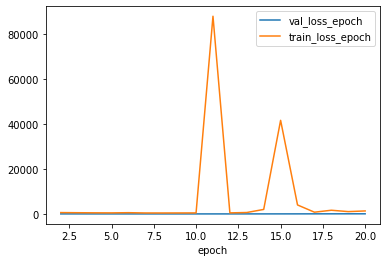

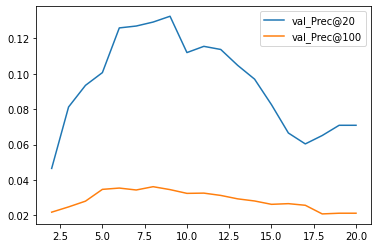

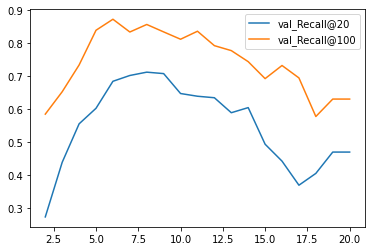

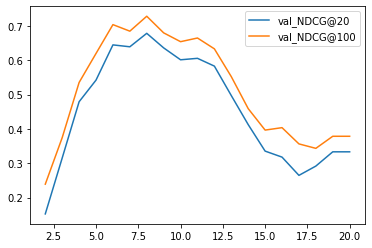

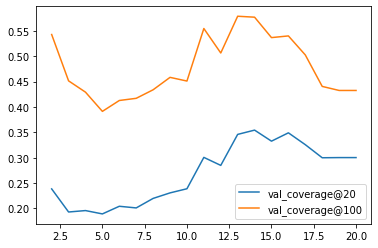

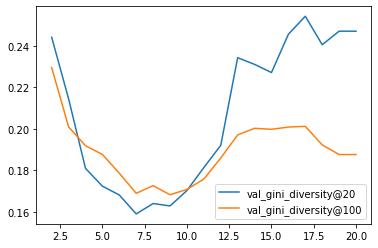

In [20]:
df_histories.filter(like="epoch").set_index("epoch")[2:].plot()
df_histories.filter(like="val_Prec")[2:].plot()
df_histories.filter(like="val_Rec")[2:].plot()
df_histories.filter(like="NDCG")[2:].plot()
df_histories.filter(like="cov")[2:].plot()
df_histories.filter(like="divers")[2:].plot()

In [21]:
new_model = MVAERecommender(model_conf, novelty_per_item, num_users, num_items, remove_observed=False)
new_model.eval()
new_model.load_state_dict(model.state_dict())

<All keys matched successfully>

In [22]:
# trainer = pl.Trainer(accelerator="auto", max_epochs=epochs, log_every_n_steps=100)
out = trainer.test(model = new_model, dataloaders=test_loader)

Testing: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:96: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:101: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_NDCG@100       │    0.30192659904642277    │
│       test_NDCG@20        │    0.2134002042707672     │
│       test_Prec@100       │    0.03697050049718263    │
│       test_Prec@20        │    0.09363606231355653    │
│      test_Recall@100      │    0.5273892387581482     │
│      test_Recall@20       │    0.26646779361396533    │
│     test_coverage@100     │    0.37474802136421204    │
│     test_coverage@20      │    0.2647709846496582     │
│  test_gini_diversity@100  │    0.20291663411314434    │
│  test_gini_diversity@20   │    0.2523442907373035     │
│      test_loss_epoch      │     259.3929748535156     │
│     test_novelty@100      │    2.6796335723074827     │
│      test_novelty@20      │    2.6718114432173596     │
└───────────────────────────┴───────────────────────────┘

## Sample Recos

In [23]:
df_items = pd.read_csv("/kaggle/input/movielens-1m-dataset/movies.csv", sep=';',encoding='latin-1').drop(columns=['Unnamed: 3'],)
id_to_name = df_items[["movieId","title"]]
dict_id_to_name = id_to_name.set_index("movieId")["title"].to_dict()

vc = df_ratings[USER_ID].value_counts()
vc[vc < 25]

799     24
5934    24
1353    24
4278    24
4872    24
        ..
2686     5
4192     5
1091     5
4365     5
3488     5
Name: userId, Length: 1303, dtype: int64

In [24]:
# 1558 = Dark Knight
# 1042 = Ratatouille
# 2196 = Spy who loved me
# 1246 = Rambo
# 818 = Rashomon
# 2481 = The Haunting
    
inference_users = [3287, 1157, 1713, 1558, 1042, 2196, 1246, 818, 2481]

In [25]:
inference_users_idx = [rid_to_idx[v] for v in inference_users]
inference_ratings_matrix = interactions[inference_users_idx].astype(np.float32)

inference_loader = torch.utils.data.DataLoader(RecoSparseDataset(inference_ratings_matrix), batch_size=1, 
                                               shuffle=False, num_workers=num_workers)
preds = trainer.predict(model=new_model, dataloaders=inference_loader)

Predicting: 12it [00:00, ?it/s]

In [26]:
for idx, pred in enumerate(preds):
    # interactions
    item_interactions = df_ratings[df_ratings[USER_ID] == inference_users[idx]][ITEM_ID].to_list()
    item_interactions_titles = df_ratings[df_ratings[USER_ID] == inference_users[idx]].merge(id_to_name)["title"].tolist()
    # recos
    # squeeze
    pred = pred[0]
    item_recos = [idx_to_cid[idx] for idx in pred]
    item_recos = [dict_id_to_name[v] for v in item_recos if v not in item_interactions]
    
    df_display = pd.DataFrame([item_interactions_titles, item_recos]).T
    df_display.columns = ["Bought Items", "Recos"]
    display(df_display)

,Bought Items,Recos
0,"Silence of the Lambs, The (1991)",Grand Hotel (1932)
1,Walkabout (1971),Mansfield Park (1999)
2,Dr. Strangelove or,Terms of Endearment (1983)
3,Little Big Man (1970),My Fair Lady (1964)
4,Rear Window (1954),"Man and a Woman, A (Un Homme et une Femme) (1966)"
5,"African Queen, The (1951)",Ladyhawke (1985)
6,Not One Less (Yi ge dou bu neng shao) (1999),"Rainmaker, The (1997)"
7,American Beauty (1999),Shadow of a Doubt (1943)
8,"Man with the Golden Arm, The (1955)",Year of Living Dangerously (1982)
9,Field of Dreams (1989),Godfather


,Bought Items,Recos
0,Stand by Me (1986),Braveheart (1995)
1,Terminator 2,Good Will Hunting (1997)
2,Grumpier Old Men (1995),"Princess Bride, The (1987)"
3,"Last of the Mohicans, The (1992)","Shawshank Redemption, The (1994)"
4,North by Northwest (1959),Star Trek
5,Cocoon (1985),Tarzan (1999)
6,"Hunt for Red October, The (1990)",Misery (1990)
7,Grumpy Old Men (1993),Indiana Jones and the Temple of Doom (1984)
8,"Fugitive, The (1993)","Terminator, The (1984)"
9,Jurassic Park (1993),Parenthood (1989)


,Bought Items,Recos
0,Final Destination (2000),"War of the Worlds, The (1953)"
1,"Tigger Movie, The (2000)",Mission
2,"Skulls, The (2000)",X-Men (2000)
3,Beetlejuice (1988),Magnolia (1999)
4,Pitch Black (2000),Donnie Brasco (1997)
5,Mission to Mars (2000),All Quiet on the Western Front (1930)
6,U-571 (2000),American Psycho (2000)
7,"Breakfast Club, The (1985)",Legends of the Fall (1994)
8,Lethal Weapon 3 (1992),High Fidelity (2000)
9,"Patriot, The (2000)",Private Parts (1997)


,Bought Items,Recos
0,X-Men (2000),"Usual Suspects, The (1995)"
1,Terminator 2,"Christmas Story, A (1983)"
2,"Hunt for Red October, The (1990)","Silence of the Lambs, The (1991)"
3,Star Wars,Good Will Hunting (1997)
4,Top Gun (1986),"Sixth Sense, The (1999)"
5,Jurassic Park (1993),"Shawshank Redemption, The (1994)"
6,"Cell, The (2000)",Men in Black (1997)
7,Star Wars,"Terminator, The (1984)"
8,"Princess Bride, The (1987)",Back to the Future (1985)
9,Raiders of the Lost Ark (1981),Contact (1997)


,Bought Items,Recos
0,Jumanji (1995),Interview with the Vampire (1994)
1,"Nutty Professor, The (1996)",October Sky (1999)
2,"War of the Worlds, The (1953)",Dead Poets Society (1989)
3,Star Wars,Crocodile Dundee (1986)
4,"Gold Rush, The (1925)",All About Eve (1950)
5,Willow (1988),Godfather
6,Santa Claus,Starman (1984)
7,"Santa Clause, The (1994)","Crying Game, The (1992)"
8,Labyrinth (1986),"Godfather, The (1972)"
9,"Lion King, The (1994)",Witness (1985)


,Bought Items,Recos
0,Being John Malkovich (1999),"Sixth Sense, The (1999)"
1,Dead Calm (1989),"Matrix, The (1999)"
2,Erin Brockovich (2000),"Patriot, The (2000)"
3,Final Destination (2000),Office Space (1999)
4,Payback (1999),Gladiator (2000)
5,Boiler Room (2000),Ghostbusters (1984)
6,Instinct (1999),South Park
7,Mission,Saving Private Ryan (1998)
8,"13th Warrior, The (1999)",Galaxy Quest (1999)
9,American Beauty (1999),"Usual Suspects, The (1995)"


,Bought Items,Recos
0,Who Framed Roger Rabbit? (1988),"Shining, The (1980)"
1,Nikita (La Femme Nikita) (1990),GoodFellas (1990)
2,X-Men (2000),"Sixth Sense, The (1999)"
3,Wallace & Gromit,"Exorcist, The (1973)"
4,"Negotiator, The (1998)",Dr. Strangelove or
...,...,...
329,"Terminator, The (1984)",None
330,Glory (1989),None
331,Scary Movie (2000),None
332,Flight of the Navigator (1986),None


,Bought Items,Recos
0,Who Framed Roger Rabbit? (1988),American Beauty (1999)
1,X-Men (2000),Star Wars
2,"Negotiator, The (1998)","Christmas Story, A (1983)"
3,Being John Malkovich (1999),Clear and Present Danger (1994)
4,Stand by Me (1986),Legends of the Fall (1994)
5,Terminator 2,"Hunt for Red October, The (1990)"
6,Heat (1995),"Insider, The (1999)"
7,"Silence of the Lambs, The (1991)",Alien (1979)
8,Rounders (1998),Leaving Las Vegas (1995)
9,Absolute Power (1997),Raging Bull (1980)


,Bought Items,Recos
0,"Bridge on the River Kwai, The (1957)",Smoke Signals (1998)
1,Chinatown (1974),"Apartment, The (1960)"
2,"Treasure of the Sierra Madre, The (1948)",Diner (1982)
3,Better Off Dead... (1985),"Christmas Story, A (1983)"
4,"Shining, The (1980)",Frankenstein (1931)
5,"Great Escape, The (1963)",North by Northwest (1959)
6,Arsenic and Old Lace (1944),In the Heat of the Night (1967)
7,"Silence of the Lambs, The (1991)",Roger & Me (1989)
8,Back to the Future (1985),"Last Emperor, The (1987)"
9,Patton (1970),Monty Python and the Holy Grail (1974)


## Probability Distributions

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Output Logits')

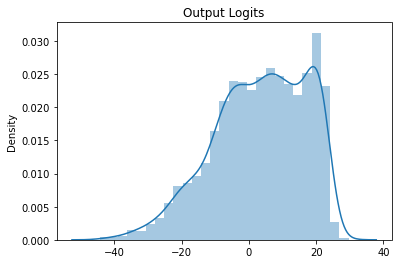

In [27]:
import seaborn as sns
out, kl_loss = new_model.forward(next(iter(inference_loader)))
plt.figure()
ax = sns.distplot(out.detach().numpy())
ax.set_title("Output Logits")

# plt.figure()
# ax = sns.distplot(new_model.encoder.weight.detach().numpy().ravel())
# ax.set_title("Encoder embeddings")

# plt.figure()
# ax = sns.distplot(new_model.decoder.weight.detach().numpy().ravel())
# ax.set_title("Decoder Weights")